# Klasyfikacja

# Autorzy

Adam Dohojda, Kacper Kiereś, Dawid Koceniak, Wiktoria Stęczna

Import bibliotek

In [320]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC
from sklearn.linear_model import Perceptron
from sklearn.preprocessing import LabelEncoder
from sklearn import datasets
from matplotlib.colors import ListedColormap

Wczytywanie danych

In [321]:
# data = pd.read_excel("hour.xlsx", header = None)
# y = data.loc[1:, 2].values
# X = data.loc[1:, 3:].values

# df = pd.read_excel('wine.xlsx', header = None)
# X = df.loc[1:, :10].values
# y = df.loc[1:, 11]. values

df = pd.read_excel('rice.xlsx', header=None)
## 0 - Cammeo
## 1 - Osmancik

df[7] = df[7].replace({'Cammeo': 0, 'Osmancik': 1})  # Zmiana wartości w kolumnie 7

X = df.loc[1:, :6].values
y = df.loc[1:, 7].values

# print("Zmienna X:")
# print(X)
# print("\nZmienna y:")
# print(y)

In [322]:
le = LabelEncoder()
y = le.fit_transform(y)
print("Class labels: ", le.classes_)

Class labels:  [0 1]


Dzielenie obserwacji na próbę treningową i próbę testową.

In [323]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size = 0.3, 
                     stratify = y,
                     random_state = 0)

In [324]:
print('Labels counts in y: ', np.bincount(y))
print('Labels counts in y_train: ', np.bincount(y_train))
print('Labels counts in y_test: ', np.bincount(y_test))

Labels counts in y:  [1630 2180]
Labels counts in y_train:  [1141 1526]
Labels counts in y_test:  [489 654]


Standaryzacja zmiennych

In [325]:
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

Budowanie perecptrona do określneia tempa uczenia się

In [326]:
ppn = Perceptron(eta0=0.1, random_state=1)
ppn.fit(X_train_std, y_train)

Perceptron(eta0=0.1, random_state=1)

In [327]:
y_pred = ppn.predict(X_test_std)
print('Misclassified examples: %d' % (y_test != y_pred).sum())

Misclassified examples: 306


In [328]:
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

Accuracy: 0.732


In [329]:
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    # Setup marker generator and color map
    markers = ('o', 's', '^', 'v', '<', '>', 'D', 'P', 'X', '*')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan', 'orange', 'purple', 'pink', 'yellow', 'black')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # Plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    # Plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=f'Class {cl}',
                    edgecolor='black')


In [330]:
from sklearn.pipeline import make_pipeline
pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components = 2),
                        LogisticRegression())
pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
test_acc = pipe_lr.score(X_test, y_test)
print(f'Test accuracy: {test_acc: .3f}')

Test accuracy:  0.920


In [331]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits = 10).split(X_train, y_train)
scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print(f'Fold: {k+1:02d}, '
          f'Class distr.: {np.bincount(y_train[train])}, '
          f'Acc.: {score:.3f}')

Fold: 01, Class distr.: [1026 1374], Acc.: 0.936
Fold: 02, Class distr.: [1027 1373], Acc.: 0.925
Fold: 03, Class distr.: [1027 1373], Acc.: 0.921
Fold: 04, Class distr.: [1027 1373], Acc.: 0.918
Fold: 05, Class distr.: [1027 1373], Acc.: 0.966
Fold: 06, Class distr.: [1027 1373], Acc.: 0.921
Fold: 07, Class distr.: [1027 1373], Acc.: 0.918
Fold: 08, Class distr.: [1027 1374], Acc.: 0.895
Fold: 09, Class distr.: [1027 1374], Acc.: 0.921
Fold: 10, Class distr.: [1027 1374], Acc.: 0.932


In [332]:
mean_acc = np.mean(scores)
std_acc = np.std(scores)
print(f'\nCV accuracy: {mean_acc:.3f} +/- {std_acc:.3f}')


CV accuracy: 0.925 +/- 0.017


In [333]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(estimator = pipe_lr,
                         X = X_train,
                         y = y_train,
                         cv = 10,
                         n_jobs = 1)
print(f'CV accuracy scores: {np.mean(scores):.3f}'
      f' +/- {np.std(scores):.3f}')

CV accuracy scores: 0.925 +/- 0.017


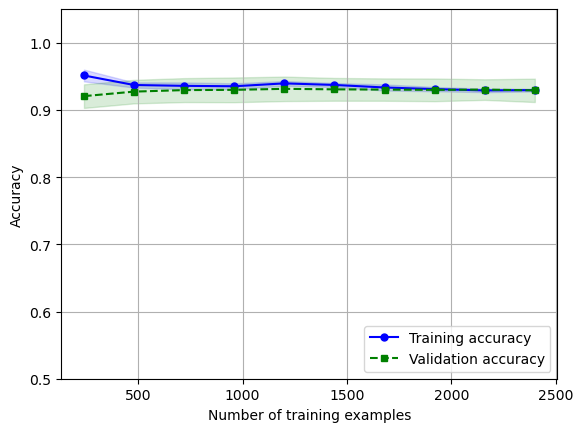

In [334]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
pipe_lr = make_pipeline(StandardScaler(),
                        LogisticRegression(penalty='l2',
                                           max_iter=10000))
train_sizes, train_scores, test_scores = \
    learning_curve(estimator=pipe_lr,
                   X=X_train,
                   y=y_train,
                   train_sizes=np.linspace(
                       0.1, 1.0, 10),
                       cv=10,
                       n_jobs=1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')
plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')
plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.5, 1.05])
plt.show()


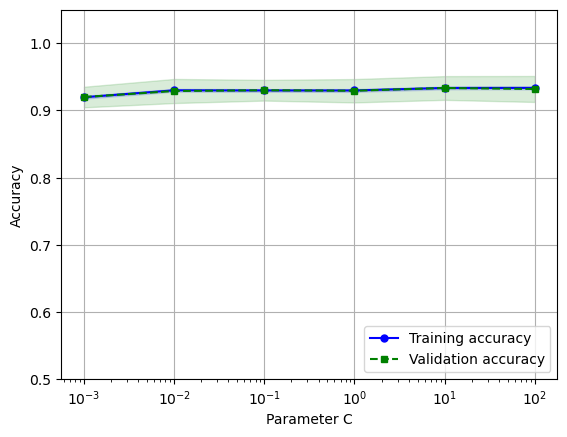

In [335]:
from sklearn.model_selection import validation_curve
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(
    estimator = pipe_lr,
    X = X_train,
    y = y_train,
    param_name = 'logisticregression__C',
    param_range = param_range,
    cv = 10)
train_mean = np.mean(train_scores , axis = 1)
train_std = np.std(train_scores, axis = 1)
test_mean = np.mean(test_scores, axis = 1)
test_std = np.std(test_scores, axis = 1)
plt.plot(param_range, train_mean, color = 'blue',
         marker = 'o', markersize = 5, 
         label = 'Training accuracy')
plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha = 0.15,
                 color = 'blue')
plt.plot(param_range, test_mean,
         color = 'green', linestyle = '--',
         marker = 's', markersize = 5,
         label = 'Validation accuracy')
plt.fill_between(param_range,
          test_mean + test_std,
          test_mean - test_std,
          alpha = 0.15, color = 'green')
plt.grid()
plt.xscale('log')
plt.legend(loc = 'lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1.05])
plt.show()

In [336]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
pipe_svc = make_pipeline(StandardScaler(),
                         SVC(random_state = 1))
param_range = [0.001, 0.01, 0.1,
               1.0, 10.0, 100.0]
param_grid = [{'svc__C': param_range,
               'svc__kernel': ['linear']},
               {'svc__C': param_range,
                'svc__gamma': param_range,
                'svc__kernel':['rbf']}]
gs = GridSearchCV(estimator = pipe_svc,
                  param_grid = param_grid,
                  scoring = 'accuracy',
                  cv = 10,
                  refit = True,
                  n_jobs = -1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9328743206330433
{'svc__C': 10.0, 'svc__kernel': 'linear'}


In [337]:
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print(f'Test accuracy: {clf.score(X_test, y_test):.3f}')

Test accuracy: 0.919


In [338]:
import scipy.stats
param_range = [0.0001, 0.001, 0.01, 0.1,
                1.0, 10.0, 100.0, 1000.0]
param_range = scipy.stats.loguniform(0.0001, 1000.0)

In [339]:
np.random.seed(1)
param_range.rvs(10)

array([8.30145146e-02, 1.10222804e+01, 1.00184520e-04, 1.30715777e-02,
       1.06485687e-03, 4.42965766e-04, 2.01289666e-03, 2.62376594e-02,
       5.98924832e-02, 5.91176467e-01])

In [340]:
from sklearn.model_selection import RandomizedSearchCV
pipe_svc = make_pipeline(StandardScaler(),
                         SVC(random_state = 1))
param_grid = [{'svc__C': param_range,
               'svc__kernel': ['linear']},
               {'svc__C': param_range,
                'svc__gamma': param_range,
                'svc__kernel': ['rbf']}]

rs = RandomizedSearchCV(estimator=pipe_svc,
                        param_distributions=param_grid,
                        scoring='accuracy',
                        refit=True,
                        n_iter=20,
                        cv=10,
                        random_state=1,
                        n_jobs=-1)

rs = rs.fit(X_train, y_train)
print(rs.best_score_)
print(rs.best_params_)

0.9317507251274254
{'svc__C': 17.264721642756914, 'svc__kernel': 'linear'}


In [341]:
param_range = [0.001, 0.01, 0.1,
                1.0, 10.0, 100.0]
param_grid = [{'svc__C': param_range,
               'svc__kernel': ['linear']},
               {'svc__C': param_range,
                'svc__gamma': param_range,
                'svc__kernel': ['rbf']}]
gs = GridSearchCV(estimator = pipe_svc,
                  param_grid = param_grid,
                  scoring = 'accuracy',
                  cv = 10)
scores = cross_val_score(gs, X_train, y_train,
                         scoring = 'accuracy', cv = 5)
print(f'CV accuracy: {np.mean(scores):.3f}'
      f' +/- {np.std(scores):.3f}')

CV accuracy: 0.931 +/- 0.016


In [342]:
from sklearn.tree import DecisionTreeClassifier
gs = GridSearchCV(
    estimator = DecisionTreeClassifier(random_state = 0),
    param_grid = [{'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}],
    scoring = 'accuracy',
    cv = 2
)
scores = cross_val_score(gs, X_train, y_train,
                         scoring = 'accuracy', cv = 5)
print(f'CV accuracy: {np.mean(scores):.3f} '
      f' +/- {np.std(scores):.3f}')

CV accuracy: 0.926  +/- 0.015


## Macierz pomyłek

In [343]:
from sklearn.metrics import confusion_matrix
pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true = y_test, y_pred = y_pred)
print(confmat)

[[442  47]
 [ 39 615]]


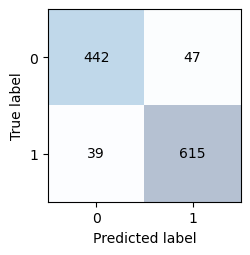

In [344]:
fig, ax = plt.subplots(figsize = (2.5, 2.5))
ax.matshow(confmat, cmap = plt.cm.Blues, alpha = 0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x = j, y = i, s = confmat[i, j],
                va = 'center', ha = 'center')
        
ax.xaxis.set_ticks_position('bottom')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [345]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score
from sklearn.metrics import matthews_corrcoef

pre_val = precision_score(y_true = y_test, y_pred = y_pred)
print(f'Precision: {pre_val}')

rec_val = recall_score(y_true = y_test, y_pred = y_pred)
print(f'Recall: {rec_val}')

f1_val = f1_score(y_true = y_test, y_pred = y_pred)
print(f'F1: {f1_val}')

mcc_val = matthews_corrcoef(y_true = y_test, y_pred = y_pred)
print(f'MCC: {mcc_val:.3f}')

Precision: 0.9290030211480362
Recall: 0.9403669724770642
F1: 0.9346504559270516
MCC: 0.846


In [346]:
from sklearn.metrics import make_scorer
c_gamma_range = [0.01, 0.1, 1.0, 10.0]
param_grid = [{'svc__C': c_gamma_range,
               'svc__kernel': ['linear']},
               {'svc__C': c_gamma_range,
                'svc__gamma': c_gamma_range,
                'svc__kernel': ['rbf']}]
scorer = make_scorer(f1_score, pos_label = 0)
gs = GridSearchCV(estimator = pipe_svc,
                  param_grid = param_grid,
                  scoring = scorer,
                  cv = 2)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9215899654802451
{'svc__C': 10.0, 'svc__kernel': 'linear'}


## Krzywa ROC

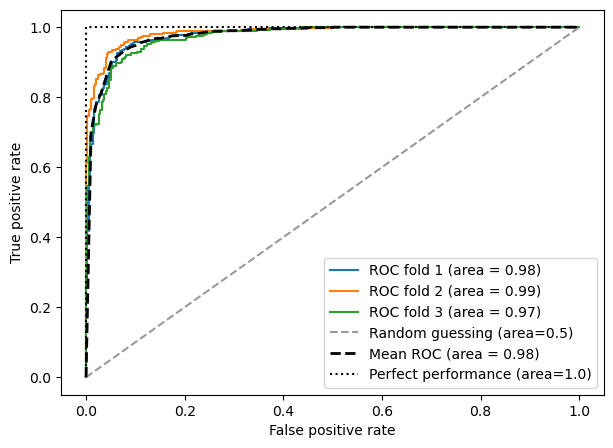

In [347]:
from sklearn.metrics import roc_curve, auc
from numpy import interp
pipe_lr = make_pipeline(
    StandardScaler(),
    PCA(n_components = 2),
    LogisticRegression(penalty = 'l2', random_state = 1,
                       solver = 'lbfgs', C = 100.0)
)
X_train2 = X_train[:, [1, 2]]
cv = list(StratifiedKFold(n_splits=3).split(X_train, y_train))
fig = plt.figure(figsize=(7, 5))
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []
for i, (train, test) in enumerate(cv):
     probas = pipe_lr.fit(
          X_train2[train],
          y_train[train]).predict_proba(X_train2[test])
     fpr, tpr, thresholds = roc_curve(y_train[test],
                                      probas[:, 1],
                                      pos_label=1)
     mean_tpr += interp(mean_fpr, fpr, tpr)
     mean_tpr[0] = 0.0
     roc_auc = auc(fpr, tpr)
     plt.plot(fpr,
              tpr,
              label=f'ROC fold {i+1} (area = {roc_auc:.2f})')
plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='Random guessing (area=0.5)')
mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label=f'Mean ROC (area = {mean_auc:.2f})', lw=2)
plt.plot([0, 0, 1],
         [0, 1, 1],
         linestyle=':',
         color='black',
         label='Perfect performance (area=1.0)')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='lower right')
plt.show()

# PCA

Inicjalizacja tranformatora PCA i estymatora regresji logistycznej

In [348]:
pca = PCA(n_components = 2)
lr = LogisticRegression(multi_class = 'ovr',
                        random_state = 1,
                        solver = 'lbfgs')

Redukcja wymiarów

In [349]:
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

Dopasowywanie modelu regresji logistycznej do zrredukowanego zbioru danych

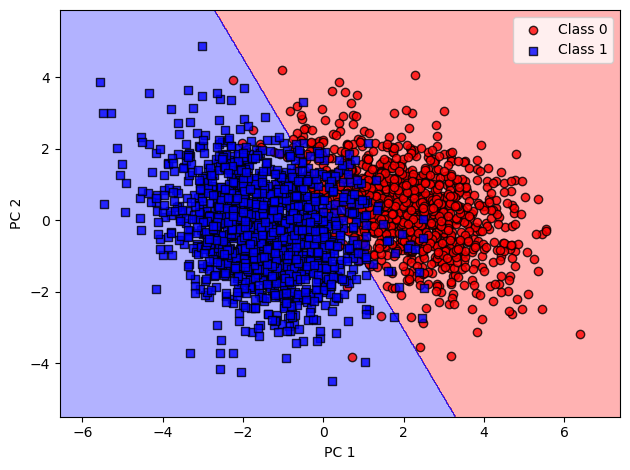

In [350]:
lr.fit(X_train_pca, y_train)
plot_decision_regions(X_train_pca, y_train, classifier = lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

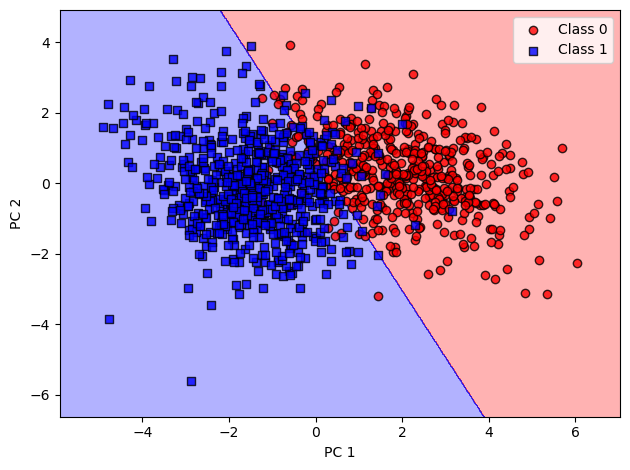

In [351]:
plot_decision_regions(X_test_pca, y_test, classifier = lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

# LDA

In [352]:
# lda = LDA(n_components=1)
# X_train_lda = lda.fit_transform(X_train_std, y_train)
# lr = LogisticRegression(multi_class='ovr', random_state=1,
#                         solver='lbfgs')
# lr = lr.fit(X_train_lda, y_train)
# plot_decision_regions(X_train_lda, y_train, classifier=lr)
# plt.xlabel('LD 1')
# plt.ylabel('LD 2')
# plt.legend(loc='lower left')
# plt.tight_layout()
# plt.show()


In [353]:
# X_test_lda = lda.transform(X_test_std)
# plot_decision_regions(X_test_lda, y_test, classifier=lr)
# plt.xlabel('LD 1')
# plt.ylabel('LD 2')
# plt.legend(loc='lower left')
# plt.tight_layout()
# plt.show()

# SVM

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

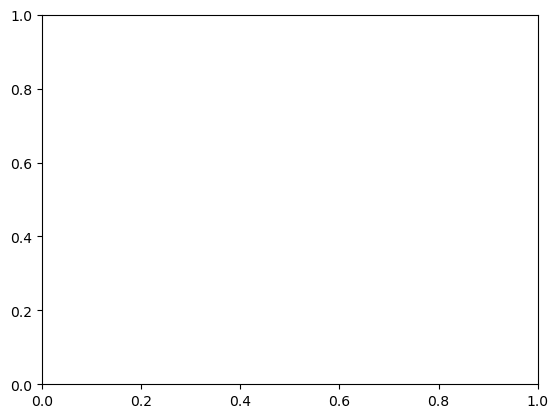

In [354]:
# df = pd.read_excel('rice.xlsx')
# X = df[['Area','Perimeter']]
# y = df['Class']

# X_train, X_test, y_train, y_test = train_test_split(
#      X, y, test_size=0.3, random_state=1, stratify=y)

# sc = StandardScaler()
# sc.fit(X_train)
# X_train_std = sc.transform(X_train)
# X_test_std = sc.transform(X_test)

# X_combined_std = np.vstack((X_train_std, X_test_std))
# y_combined = np.hstack((y_train, y_test))


# svm = SVC(kernel = 'linear', C = 1.0, random_state = 1)
# svm.fit(X_train_std, y_train)
# plot_decision_regions(X_combined_std,
#                       y = y_combined,
#                       classifier = svm,
#                       test_idx = range(105, 150))
# plt.xlabel('pH [standardized]')
# plt.ylabel('alcohol [standardized]')
# plt.legend(loc = 'upper left')
# plt.tight_layout()
# plt.show()


# knn

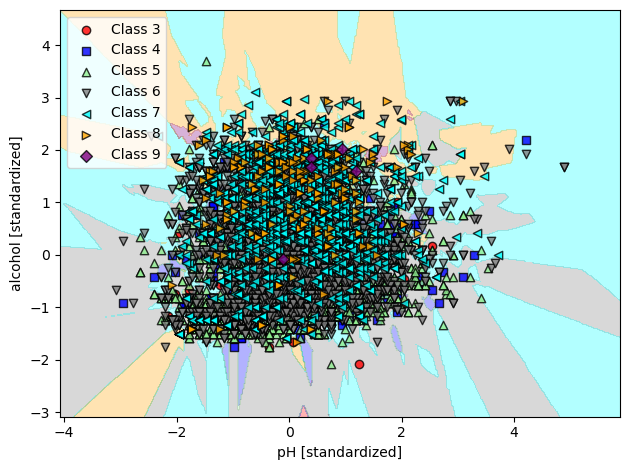

In [ ]:
# from sklearn.neighbors import KNeighborsClassifier
# knn = KNeighborsClassifier(n_neighbors=5, p=2,
#                             metric='minkowski')
# knn.fit(X_train_std, y_train)
# plot_decision_regions(X_combined_std, y_combined,
#                       classifier=knn, test_idx=range(105,150))
# plt.xlabel('pH [standardized]')
# plt.ylabel('alcohol [standardized]')
# plt.legend(loc='upper left')
# plt.tight_layout()
# plt.show()